In [1]:
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
import theano
import theano.tensor as tt
from theano.tensor import fft
import pymc3 as pm
from pymc3.variational.callbacks import CheckParametersConvergence
import theano.tensor.signal.conv
import exoplanet as xo
import scipy.signal

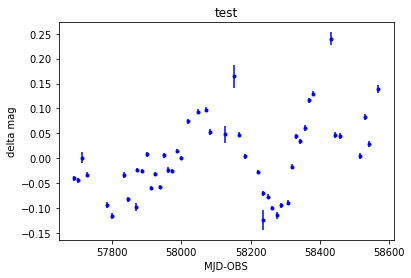

In [2]:
# Read photometry catalogue created by my other script
photfilename = 'F51_out_REMIR_ROS2.fits'
data = fits.getdata(photfilename, 1)

# The photometry catalogue contains aperture photometry in 25 different
# apertures. If we number them 0..24, they correspond to diameters 1..25 arcsec
apno = 10 # This is then 11 arcsec

# The photometry catalogue contains photometry for the AGN plus some more
# objects in the field, in this case the AGN + 6 more objetcs, so 7 in
# total. The AGN is number 1, and the others 2, 3, etc.
# This is seen in the column names, which end in _1, _2, etc.
# E.g. the column MAG_APER_1 contains the aperture magnitudes (for all
# 25 apertures) for the AGN.

# Get the aperture magnitudes
##foo = data['MAG_APER_1'] # has shape e.g. (767, 25), the 25 being the apertures
mag_agn  = data['MAG_APER_1'][:,apno]
mag_ref1 = data['MAG_APER_3'][:,apno] # I have found that _3 is good here
mag_ref2 = data['MAG_APER_4'][:,apno]

# Get the differential magnitudes
delta_mag_agn_ref1 = mag_agn - mag_ref1
delta_mag_ref2_ref1 = mag_ref2 - mag_ref1

# Get the magnitude errors 
magerr_agn = data['MAGERR_APER_1'][:,apno]
magerr_ref1 = data['MAGERR_APER_3'][:,apno]
magerr_ref2= data['MAGERR_APER_4'][:,apno]

# TODO Here I could loop over the filters, subtracting the median

# For simplicity "extract" some arrays from the data
filt = data['filter']
mjd_obs = data['mjd_obs']

# A simple plot of the J band differential mags, with the median subtracted
# Do 'H' and 'K' in the same way
maskJ = (filt == 'J')
#print(magerr_ref1[mask])
#plt.scatter(mjd_obs[mask], delta_mag_agn_ref1[mask]-np.median(delta_mag_agn_ref1[mask]))
plt.errorbar(mjd_obs[maskJ], delta_mag_agn_ref1[maskJ]-np.median(delta_mag_agn_ref1[maskJ]), magerr_ref1[maskJ],fmt='b.')
plt.title('test')
plt.xlabel('MJD-OBS')
plt.ylabel('delta mag')
plt.show()

In [3]:
#J band data
xJ=np.asarray(mjd_obs[maskJ], dtype=float)
nJ=len(xJ)
XJ = np.reshape(xJ,(nJ,1))
yJ=np.asarray(delta_mag_agn_ref1[maskJ]-np.median(delta_mag_agn_ref1[maskJ]), dtype=float)
yJerr = np.array(magerr_ref1[maskJ], dtype=float)

#H band data
maskH = (filt == 'H')
xHtemp=np.asarray(mjd_obs[maskH], dtype=float)
xH=np.delete(xHtemp,(1,2))
nH=len(xH)
XH = np.reshape(xH,(nH,1))
XH_new=np.linspace(min(XH),max(XH),100,dtype=np.float64)
Hdelta_mag_agn_ref1=np.delete(delta_mag_agn_ref1[maskH],(1,2))
yH=np.asarray(Hdelta_mag_agn_ref1-np.median(Hdelta_mag_agn_ref1), dtype=float)
yHerrtemp = np.asarray(magerr_ref1[maskH], dtype=float)
yHerr=np.delete(yHerrtemp,(1,2))

#K band data
maskK = (filt == 'K')
xK=np.asarray(mjd_obs[maskK], dtype=float)
nK=len(xK)
XK = np.reshape(xK,(nK,1))
yK=np.asarray(delta_mag_agn_ref1[maskK]-np.median(delta_mag_agn_ref1[maskK]), dtype=float)
yKerr = np.asarray(magerr_ref1[maskK], dtype=float)

#g band data
maskg = (filt == 'g')
gtemp=delta_mag_agn_ref1[maskg]
gisnan=~np.isnan(gtemp)
xg=np.asarray(mjd_obs[maskg][gisnan], dtype=float)
ng=len(xg)
Xg = np.reshape(xg,(ng,1))
yg=np.asarray(delta_mag_agn_ref1[maskg][gisnan]-np.median(delta_mag_agn_ref1[maskg][gisnan]), dtype=float)
ygerr = np.asarray(magerr_ref1[maskg][gisnan], dtype=float)
#remove values 
xg=xg[(yg>-0.4) & (yg<0.4)]
ng=len(xg)
Xg = np.reshape(xg,(ng,1))
ygerr=ygerr[(yg>-0.4) & (yg<0.4)]
yg=yg[(yg>-0.4) & (yg<0.4)]

#r band data
maskr = (filt == 'r')
rtemp=delta_mag_agn_ref1[maskr]
risnan=~np.isnan(rtemp)
xr=np.asarray(mjd_obs[maskr][risnan], dtype=float)
nr=len(xr)
Xr = np.reshape(xr,(nr,1))
yr=np.asarray(delta_mag_agn_ref1[maskr][risnan]-np.median(delta_mag_agn_ref1[maskr][risnan]), dtype=float)
yrerr = np.asarray(magerr_ref1[maskr][risnan], dtype=float)
#remove values 
xr=xr[(yr>-0.4) & (yr<0.4)]
nr=len(xr)
Xr = np.reshape(xr,(nr,1))
yrerr=yrerr[(yr>-0.4) & (yr<0.4)]
yr=yr[(yr>-0.4) & (yr<0.4)]

#i band data
maski = (filt == 'i')
itemp=delta_mag_agn_ref1[maski]
iisnan=~np.isnan(itemp)
xi=np.asarray(mjd_obs[maski][iisnan], dtype=float)
ni=len(xi)
Xi = np.reshape(xi,(ni,1))
yi=np.asarray(delta_mag_agn_ref1[maski][iisnan]-np.median(delta_mag_agn_ref1[maski][iisnan]), dtype=float)
yierr = np.asarray(magerr_ref1[maski][iisnan], dtype=float)
#remove values 
xi=xi[(yi>-0.4) & (yi<0.4)]
ni=len(xi)
Xi= np.reshape(xi,(ni,1))
yierr=yierr[(yi>-0.4) & (yi<0.4)]
yi=yi[(yi>-0.4) & (yi<0.4)]

#z band data
maskz = (filt == 'z')
ztemp=delta_mag_agn_ref1[maskz]
zisnan=~np.isnan(ztemp)
xz=np.asarray(mjd_obs[maskz][zisnan], dtype=float)
nz=len(xz)
Xz = np.reshape(xz,(nz,1))
yz=np.asarray(delta_mag_agn_ref1[maskz][zisnan]-np.median(delta_mag_agn_ref1[maskz][zisnan]), dtype=float)
yzerr = np.asarray(magerr_ref1[maskz][zisnan], dtype=float)
#remove values 
xz=xz[(yz>-0.4) & (yz<0.4)]
nz=len(xz)
Xz = np.reshape(xz,(nz,1))
yzerr=yzerr[(yz>-0.4) & (yz<0.4)]
yz=yz[(yz>-0.4) & (yz<0.4)]

#time array with all bands
#be carefull with how XJ and xj acts 
X_tot= np.concatenate((xJ,xH,xK,xg,xr,xi,xz),axis=None)
X_tot=np.reshape(X_tot,(len(X_tot),1))

#combine all y values for guess
Y_tot= np.concatenate((yJ,yH,yK),axis=None)

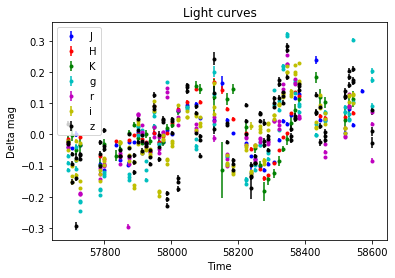

In [4]:
plt.errorbar(xJ, yJ, yJerr,fmt='b.',label='J')
plt.errorbar(xH, yH, yHerr,fmt='r.',label='H')
plt.errorbar(xK, yK, yKerr,fmt='g.',label='K')
plt.errorbar(xg, yg, ygerr,fmt='c.',label='g')
plt.errorbar(xr, yr, yrerr,fmt='m.',label='r')
plt.errorbar(xi, yi, yierr,fmt='y.',label='i')
plt.errorbar(xz, yz, yzerr,fmt='k.',label='z')
#plt.ylim(-1,1)
plt.title('Light curves')
plt.xlabel('Time')
plt.ylabel('Delta mag')
plt.legend()

In [8]:
sum(abs(yg/ygerr)/len(yg))

19.476878524822364

In [10]:
abs(yK/yKerr)

array([1.45619995, 0.03655153, 2.97371925, 1.45749363, 3.84993334,
       1.85318763, 3.81310113, 2.55554642, 0.46816348, 3.45616875,
       1.2337825 , 3.03166614, 0.        , 1.56932391, 2.66552262,
       1.27813758, 2.22935779, 1.34707539, 3.10595082, 5.93613305,
       6.09815217, 9.30050673, 9.17724658, 2.0101184 , 1.28683481,
       5.95452935, 8.7828566 , 1.44256418, 3.16950143, 7.06415689,
       6.17869517, 8.32608666, 8.27921992, 5.32686849, 4.28707562,
       0.97167749, 1.69783972, 4.2422766 , 7.23697121, 9.7029121 ,
       4.25263085, 5.82956059, 1.26960556, 2.74668094, 4.46546669])

In [11]:
ygerr

array([0.00439068, 0.00435354, 0.00438848, 0.00780835, 0.00897952,
       0.00808667, 0.00468276, 0.0046301 , 0.0046161 , 0.00512434,
       0.00511132, 0.00528504, 0.0057235 , 0.00567791, 0.00563627,
       0.00401787, 0.00414937, 0.00394342, 0.00423999, 0.00446278,
       0.00437779, 0.00502923, 0.00499161, 0.00508341, 0.00467851,
       0.00486108, 0.00449952, 0.0051898 , 0.00643761, 0.00548199,
       0.00896905, 0.00429751, 0.00507374, 0.00503726, 0.00440678,
       0.00423667, 0.00423971, 0.02026395, 0.01757916, 0.01490218,
       0.00471891, 0.00475556, 0.00472764, 0.00533299, 0.00510351,
       0.00513286, 0.00523117, 0.0051164 , 0.00477724, 0.00476519,
       0.00467402, 0.00535944, 0.0052542 , 0.00533948, 0.00425553,
       0.00427543, 0.0056339 , 0.00535101, 0.0054447 , 0.00447158,
       0.00448829, 0.00440972, 0.00442775, 0.00440082, 0.00595602,
       0.00595042, 0.00584422, 0.00746211, 0.00736486, 0.00724428,
       0.00575058, 0.00571802, 0.00566847, 0.00689483, 0.00671